In [6]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [7]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utils.utils import *

from utils.plotting import Plotter
from utils.gl_solver import GLSolver
from utils.parameters_init import ParametersInit
from utils.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
path = "allinputnet_kandz_aandb"
mtlibpath_prefix ="allinputnet_kandz_mtl_aandb"

Nx=64
Ny=64

Lx= 60
Ly= 60
T_end = 4
dt = 0.005

myubatch_size = 32768

input_to_defect_ratio_sqrt = 8
N_ITERATIONS = int(T_end / dt)
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=input_to_defect_ratio_sqrt*input_to_defect_ratio_sqrt, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=100, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:00<00:00, 1987.11it/s]


Unique Myus count	 512
Max value of myu:	 117.1843611549054
Min value of myu:	 22.239506440530576
Unique values: [22.239506440530576, 23.791315890724274, 25.927079233024294, 26.976174610675017, 27.201046313040894, 27.495451004629714, 30.073694841596442, 31.028670788184076, 31.30102833529873, 31.335988118627515, 31.869368756035204, 31.938993730609265, 32.80916610728368, 32.928346962768174, 33.95662692989527, 34.410086480228415, 34.48155109439352, 34.597430858886476, 34.88179943321419, 34.935041790733464, 34.961895088302484, 35.04624168068196, 35.4862253246974, 35.593858399267354, 35.80544203816217, 36.00965648540534, 36.346749880874725, 36.80157704622011, 36.802103163181116, 36.968244866451215, 37.340477994385324, 37.52628113851591, 37.6225269925818, 37.96117382922439, 38.05388248183619, 38.44814363654829, 38.50763557370484, 38.856851040860114, 39.10039916082149, 39.114894357078576, 39.3143825945647, 39.563859503149494, 39.73911874928465, 39.99281087575391, 40.01233008515505, 40.0167497

In [13]:
def output_plot(data, mem_rat, save_fig=False, file_name="A_in_norm_80%04d.png"):
    fig = plt.figure(1, figsize=(6.5, 6.5))
    for index in tqdm(range(mem_rat)):
        if index % 2 == 0:
            plt.clf()
            plt.imshow(data[index, :, :], origin='lower', vmax=0.9*np.max(data))
            plt.colorbar()
            if save_fig:
                filename = file_name % (index/2)
                plt.savefig(filename)

100%|██████████| 800/800 [00:13<00:00, 57.60it/s]


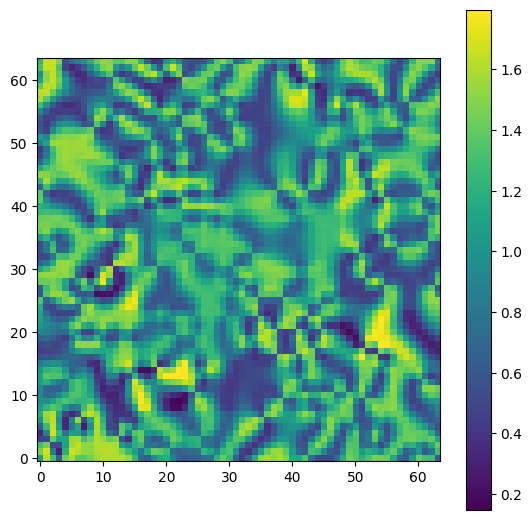

In [14]:
output_plot(A_norm, mem_rate)

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

In [11]:
x = np.linspace(0, 4, Nx).flatten()[:, None] - 2
y = np.linspace(0, 4, Ny).flatten()[:, None] - 2
t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

Exact = A_original.squeeze(0)

X, T, Y = np.meshgrid(x, t, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()
u_star = np.hstack([u_star.real[:, None],u_star.imag[:, None]])

In [ ]:
k = (u_star[:,0]*u_star[:,1]).reshape(-1,1)
z = (u_star[:,0]**2 u_star[:,1]**2).reshape(-1,1)
data = np.hstack((k,z))

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [ ]:
class ALLINPUTNET(nn.Module):
    def __init__(self, layers_list, activation_function_list = None, linm = None):
        super(ALLINPUTNET, self).__init__()
        self._depth = len(layers_list) - 1
        
        if activation_function_list is None:
            activation_function_list = [F.softplus for _ in range(self._depth - 1)]
            
        if linm is None:
            linm =  np.tril(np.ones(self._depth + 1, dtype = int))
        lin = linm@layers_list
        
        self._activation_function_list = activation_function_list
        
        self._Wtmx = nn.Sequential(*[torch.nn.Linear(lin[i], layers_list[i+1], dtype = torch.float64) for i in range(self._depth)])
        self._linm = linm
        
        self.optimizer = torch.optim.Adam( params = self._Wtmx.parameters(), lr=0.01 )    
        
    def forward(self, x):
        layers = [x,self._Wtmx[0](x)]
        for i in range(1, self._depth):
            layers[i] = self._activation_function_list[i-1](layers[i])
            ind = self._linm[i]
            inpind = np.where(ind)[0]
            inp = torch.concat([layers[i] for i in inpind], dim = -1)
            layers.append(self._Wtmx[i](inp))
        return layers[-1]        

    def predict(self, x):
        self._Wtmx.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self.forward(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j    

    def rmsef(self, y, y_pred):
        mseloss = torch.sum((y_pred - y)**2, dim = 1)
        return torch.mean(torch.sqrt(mseloss))   

    def msef(self, y, y_pred):
        return torch.mean((y_pred - y)**2)       
    
    def fastrmsebatchtrain(self, x, y, epochs=100, batch_size = 64):
        
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        dataloader = DataLoader(dataset = torch.hstack((x,y)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        L = []
        
        pbar = tqdm(total=epochs)
        try:
            while True:
                if pbar.n >= epochs:
                    break
                for tmp in dataloader:
                    (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                    X = torch.stack((tmpx,tmpy,tmpt)).T
                    U = torch.stack((tmpu_real, tmpu_img)).T

                    y_pred = self.forward(X)
                    loss = self.rmsef(y_pred,U)
                    L.append(loss.cpu().detach().numpy())
                    loss.backward()
                    self.optimizer.step()
                    self._Wtmx.zero_grad()
                    self.optimizer.zero_grad()
                    # Update the progress bar
                    if pbar.n >= epochs:
                        break
                    pbar.update(1)
                        
        except Exception as e:
            raise Exception(e)
        finally:
            # Close the progress bar
            pbar.close()          
        return L

In [ ]:
class ALLINPUTPINN(ALLINPUTNET):
    def __init__(self,*args,**kwargs):
        super(ALLINPUTPINN, self).__init__(*args,**kwargs)
#         myu = torch.randn(4, 2, dtype=torch.float64).to(device)
#         myu = nn.Parameter(myu)
#         self._Wtmx.register_parameter('myu', myu)
#         self.myuparam = myu
#         myu = transform_and_stack(myu, 4, 200).to(device).clone().requires_grad_(True)
#         self.myu = myu.view(200, 4, 4)
        self.myureset()
    
    def myureset(self):
        myu = torch.randn(mem_rate, Nx//input_to_defect_ratio_sqrt, Ny//input_to_defect_ratio_sqrt, dtype=torch.float64).to(device)
        myu = nn.Parameter(myu)
        self.myuparam = myu
        self._Wtmx.register_parameter('myu', myu)
        
    @property
    def myu(self):
        myu = F.interpolate(self.myuparam.unsqueeze(0), scale_factor=input_to_defect_ratio_sqrt, mode='nearest').squeeze()
        return myu
    
    def loaddata_precalculate(self,x):
        myuloss = MYULOSS(*tuple(x.T),self)
        myuloss.calculate_f_withoutmyu()
        self.myuloss = myuloss
    
    def fmsef(self, myu):
        return self.myuloss.fmse(myu)
    
    def fmse(self):
        return self.fmsef(self.myu)
    
    def myutrain(self, epochs=100, lr = 0.01):
        
        myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=lr ) 
        myuoptimizer.zero_grad()

        for _ in tqdm(range(epochs)):
            self.fmse().backward(retain_graph=True)
            myuoptimizer.step()
            myuoptimizer.zero_grad()
        
        FMSE = self.myuloss.FMSE
        self.myuloss.clear()
        return FMSE

In [ ]:
class MYULOSS:
  def __init__(self, x, y, t, net, verbose = 0):
      self.msef = nn.MSELoss()
      self.FMSE = []
      self.x = x
      self.y = y
      self.t = t
      self.net = net
        
  def plot(self, title= 'MYU training'):
    plt.plot(self.FMSE)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('FMSE')
    self.clear()
    
  def clear(self):
    self.FMSE = []
    
  def fmse(self, myu):
    f_loss = torch.mean(torch.abs(self.net_f(myu)) ** 2)
    self.FMSE.append(f_loss.cpu().detach().numpy())
    return f_loss
  
  def net_f(self, myu, verbose = 0):
        return self.f_withoutmyu - myu*self.u 
    
  def calculate_f_withoutmyu(self):
        x,y,t = self.x, self.y, self.t
        
        u, u_t,u_xx,u_yy = MYULOSS.pref(x,y,t,net)
        
        self.u = u.cpu().detach()
            
        f_withoutmyu = u_t - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u #- myu*u
        self.f_withoutmyu = f_withoutmyu.cpu().detach()
        free_memory(u_t, u_xx, u_yy, u, f_withoutmyu)

    
  def f_withoutmyu(x,y,t,ru,iu):
        (ru_t, ru_x, ru_y) = torch.autograd.grad(ru, (t, x, y), grad_outputs=torch.ones_like(ru), create_graph=True, retain_graph=True)
        (iu_t, iu_x, iu_y) = torch.autograd.grad(iu, (t, x, y), grad_outputs=torch.ones_like(iu), create_graph=True, retain_graph=True)

        (ru_xx,) = torch.autograd.grad(ru_x, (x), grad_outputs=torch.ones_like(ru_x), create_graph=True)
        (iu_xx,) = torch.autograd.grad(iu_x, (x), grad_outputs=torch.ones_like(iu_x), create_graph=True)

        (ru_yy,) = torch.autograd.grad(ru_y, (y), grad_outputs=torch.ones_like(ru_y), create_graph=True)
        (iu_yy,) = torch.autograd.grad(iu_y, (y), grad_outputs=torch.ones_like(iu_y), create_graph=True)

        u =( ru + iu * 1j)
        u_t = (ru_t + iu_t * 1j)
        u_xx =( ru_xx + iu_xx *1j)
        u_yy = (ru_yy + iu_yy *1j)
        
        return u, u_t,u_xx,u_yy
    
  def pref(x,y,t, net, batch_size = myubatch_size):
    dataloader = DataLoader(dataset = X_star, batch_size = batch_size, shuffle=False)
    cache = {
        'u':[],
        'u_t':[],
        'u_xx':[],
        'u_yy':[],
    }
    for tmp in tqdm(dataloader):
        x,y,t = torch.tensor(tmp.T, dtype = torch.float64, requires_grad=True).to(device)
        ru,iu = net.forward(torch.stack((x,y,t)).T).T
        u, u_t,u_xx,u_yy = MYULOSS.f_withoutmyu(x,y,t,ru,iu)
        cache['u'].append(u.cpu().detach())
        cache['u_t'].append(u_t.cpu().detach())
        cache['u_xx'].append(u_xx.cpu().detach())
        cache['u_yy'].append(u_yy.cpu().detach())
        
    return  torch.cat(cache['u']).view(mem_rate, Nx, Ny), \
            torch.cat(cache['u_t']).view(mem_rate, Nx, Ny),\
            torch.cat(cache['u_xx']).view(mem_rate, Nx, Ny),\
            torch.cat(cache['u_yy']).view(mem_rate, Nx, Ny)

      
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [ ]:
torch.manual_seed(0)
device = 'cpu'
net = ALLINPUTPINN([3,8,32,64,32,8,2]).to(device)
net

ALLINPUTPINN(
  (_Wtmx): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): Linear(in_features=11, out_features=32, bias=True)
    (2): Linear(in_features=43, out_features=64, bias=True)
    (3): Linear(in_features=107, out_features=32, bias=True)
    (4): Linear(in_features=139, out_features=8, bias=True)
    (5): Linear(in_features=147, out_features=2, bias=True)
  )
)

In [ ]:
L1 = net.fastrmsebatchtrain(x = X_star, y = data , epochs = 100000)

100%|████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:40<00:00, 990.43it/s]


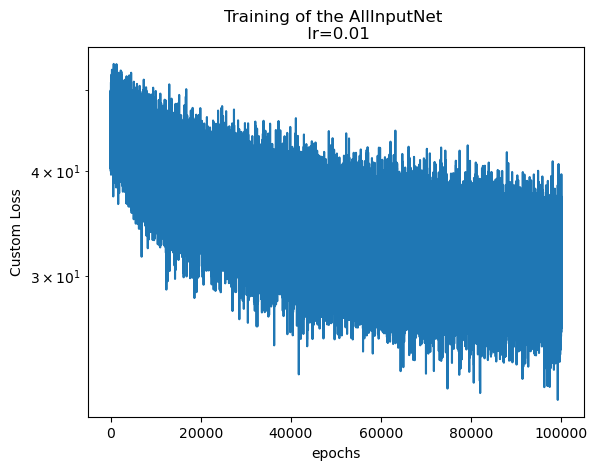

In [ ]:
plt.plot(L1)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.01')
plt.savefig(f'{mtlibpath_prefix}_allinputnet001.png')

In [ ]:
net.optimizer.param_groups[0]['lr'] = 0.001
L2 = net.fastrmsebatchtrain(x = X_star, y = data, epochs = 100000)

100%|████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:47<00:00, 930.65it/s]


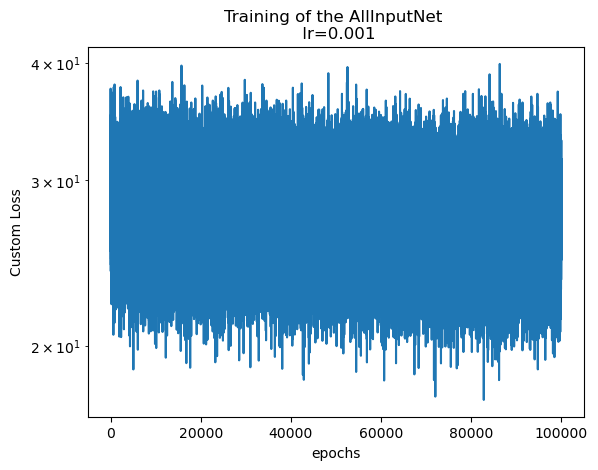

In [ ]:
plt.plot(L2)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.001')
plt.savefig(f'{mtlibpath_prefix}_allinputnet0001.png')

In [ ]:
A2 = net.predict(X_star)

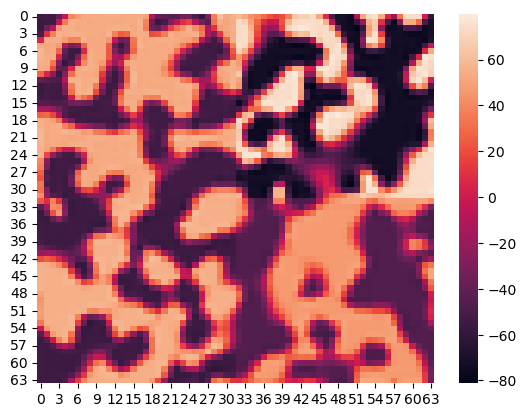

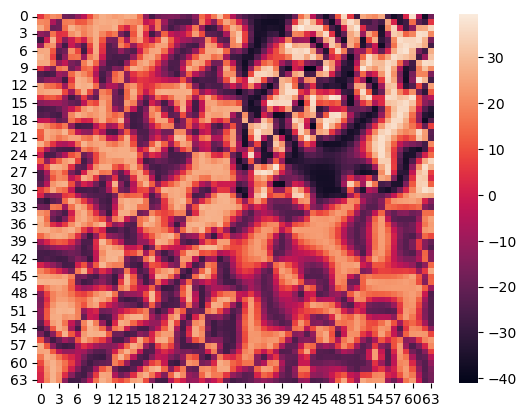

In [ ]:
sns.heatmap((np.real(A_original)*np.abs(np.real(A_original))+np.imag(A_original)*np.abs(np.imag(A_original)).reshape(A_original.shape))[0][-1])
plt.show()
sns.heatmap(((np.real(A_original)*np.imag(A_original)).reshape(A_original.shape))[0][-1])
plt.show()

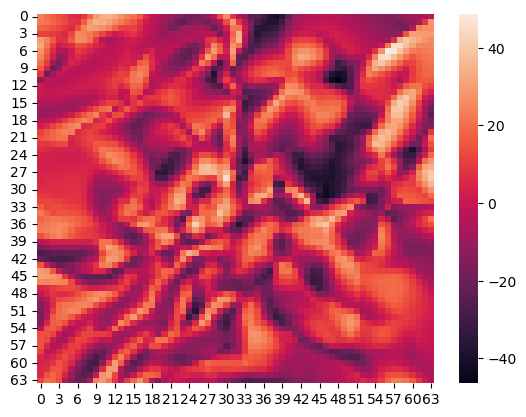

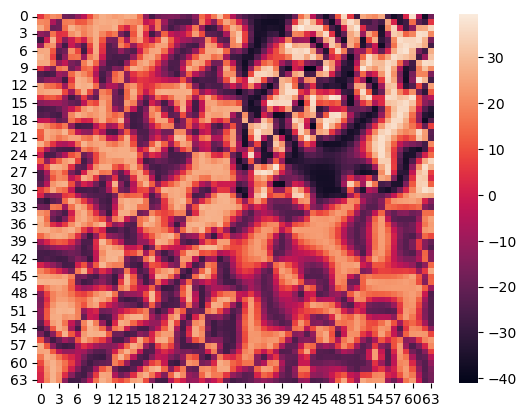

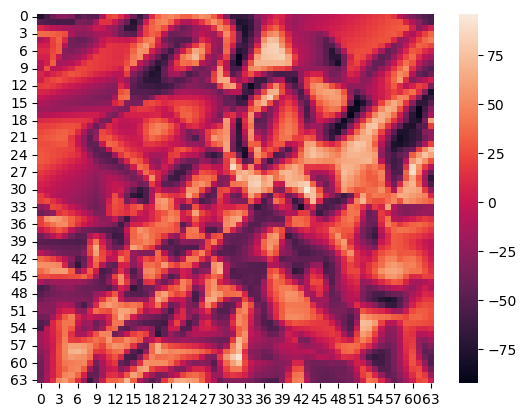

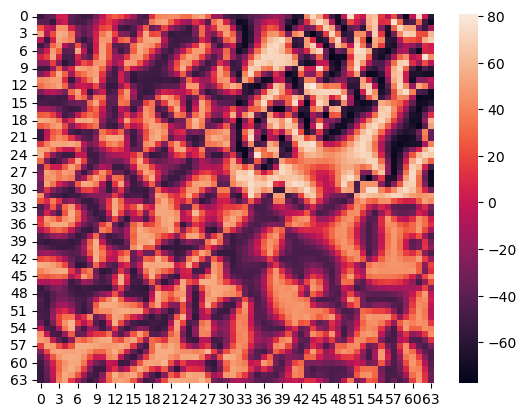

In [ ]:
import seaborn as sns
sns.heatmap(((np.real(A2)).reshape(A_original.shape))[0][-1])
plt.show()
sns.heatmap(((np.real(A_original)*np.imag(A_original)).reshape(A_original.shape))[0][-1])
plt.show()
sns.heatmap(((np.imag(A2)).reshape(A_original.shape))[0][-1])
plt.show()
sns.heatmap(((np.real(A_original)**2-np.imag(A_original)**2).reshape(A_original.shape))[0][-1])
plt.show()

In [ ]:
A_original.shape

(1, 800, 64, 64)

In [ ]:
u_star

array([[-1.1738239e-02, -1.0015376e-02],
       [-2.7988695e-02,  1.7934423e-03],
       [-1.6606255e-02,  1.9798898e-03],
       ...,
       [ 6.9435825e+00, -2.4839623e-01],
       [ 5.5672760e+00, -4.2045031e+00],
       [ 2.6646633e+00, -6.5252652e+00]], dtype=float32)

In [ ]:
module = np.abs(A2-A_original.reshape(-1))

In [ ]:
np.mean(module**2)

1470.511625184442

In [ ]:
create_gifs(
    memory_rate=mem_rate,
    u_pred=A2,
    original=A_original,
    save=True,
    path_for_gif=path+".gif",
    duration=500,
    title=" "
)
Image(filename=path+".gif")

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:54<00:00, 14.70it/s]


KeyboardInterrupt: 